<a href="https://colab.research.google.com/github/MelissaKR/forecasting_exercise/blob/master/TimeSeries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store-Item Demand Forecasting Kaggle Challenge
We are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

In [1]:
import math
import sys
import time
import numpy as np
import pandas as pd

import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

import keras
from tensorflow.keras.layers import LayerNormalization
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from plotly.offline import iplot
import plotly.graph_objs as go

Tensorflow version: 2.2.0


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('/train.csv', parse_dates=['date'])
test = pd.read_csv('/test.csv', parse_dates=['date'])

In [55]:
print('Train Dataset Shape: {}'.format(train.shape))
print('Test Dataset Shape: {}'.format(test.shape))

Train Dataset Shape: (913000, 4)
Test Dataset Shape: (45000, 4)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [ ]:
print('There are {} null values in train dataset'.format(train.isnull().values.sum()))
print('There are {} null values in test dataset'.format(test.isnull().values.sum()))

There are 0 null values in train dataset
There are 0 null values in test dataset


In [ ]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [56]:
print("The training dataset is from {} to {}".format(train['date'].min(), test['date'].max()))
print("The testing dataset is from {} to {}".format(train['date'].min(), test['date'].max()))

The training dataset is from 2013-01-01 00:00:00 to 2018-03-31 00:00:00
The testing dataset is from 2013-01-01 00:00:00 to 2018-03-31 00:00:00


# EDA

In [3]:
daily_store_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
daily_item_sales = train.groupby(['item','date'], as_index=False)['sales'].sum()
daily_sales = train.groupby('date', as_index=False)['sales'].sum()

## Time Series Visualizations

Let's first look at the trends and patterns of total sales, store sales and item sales across the 5-year data in "train" DataFrame.

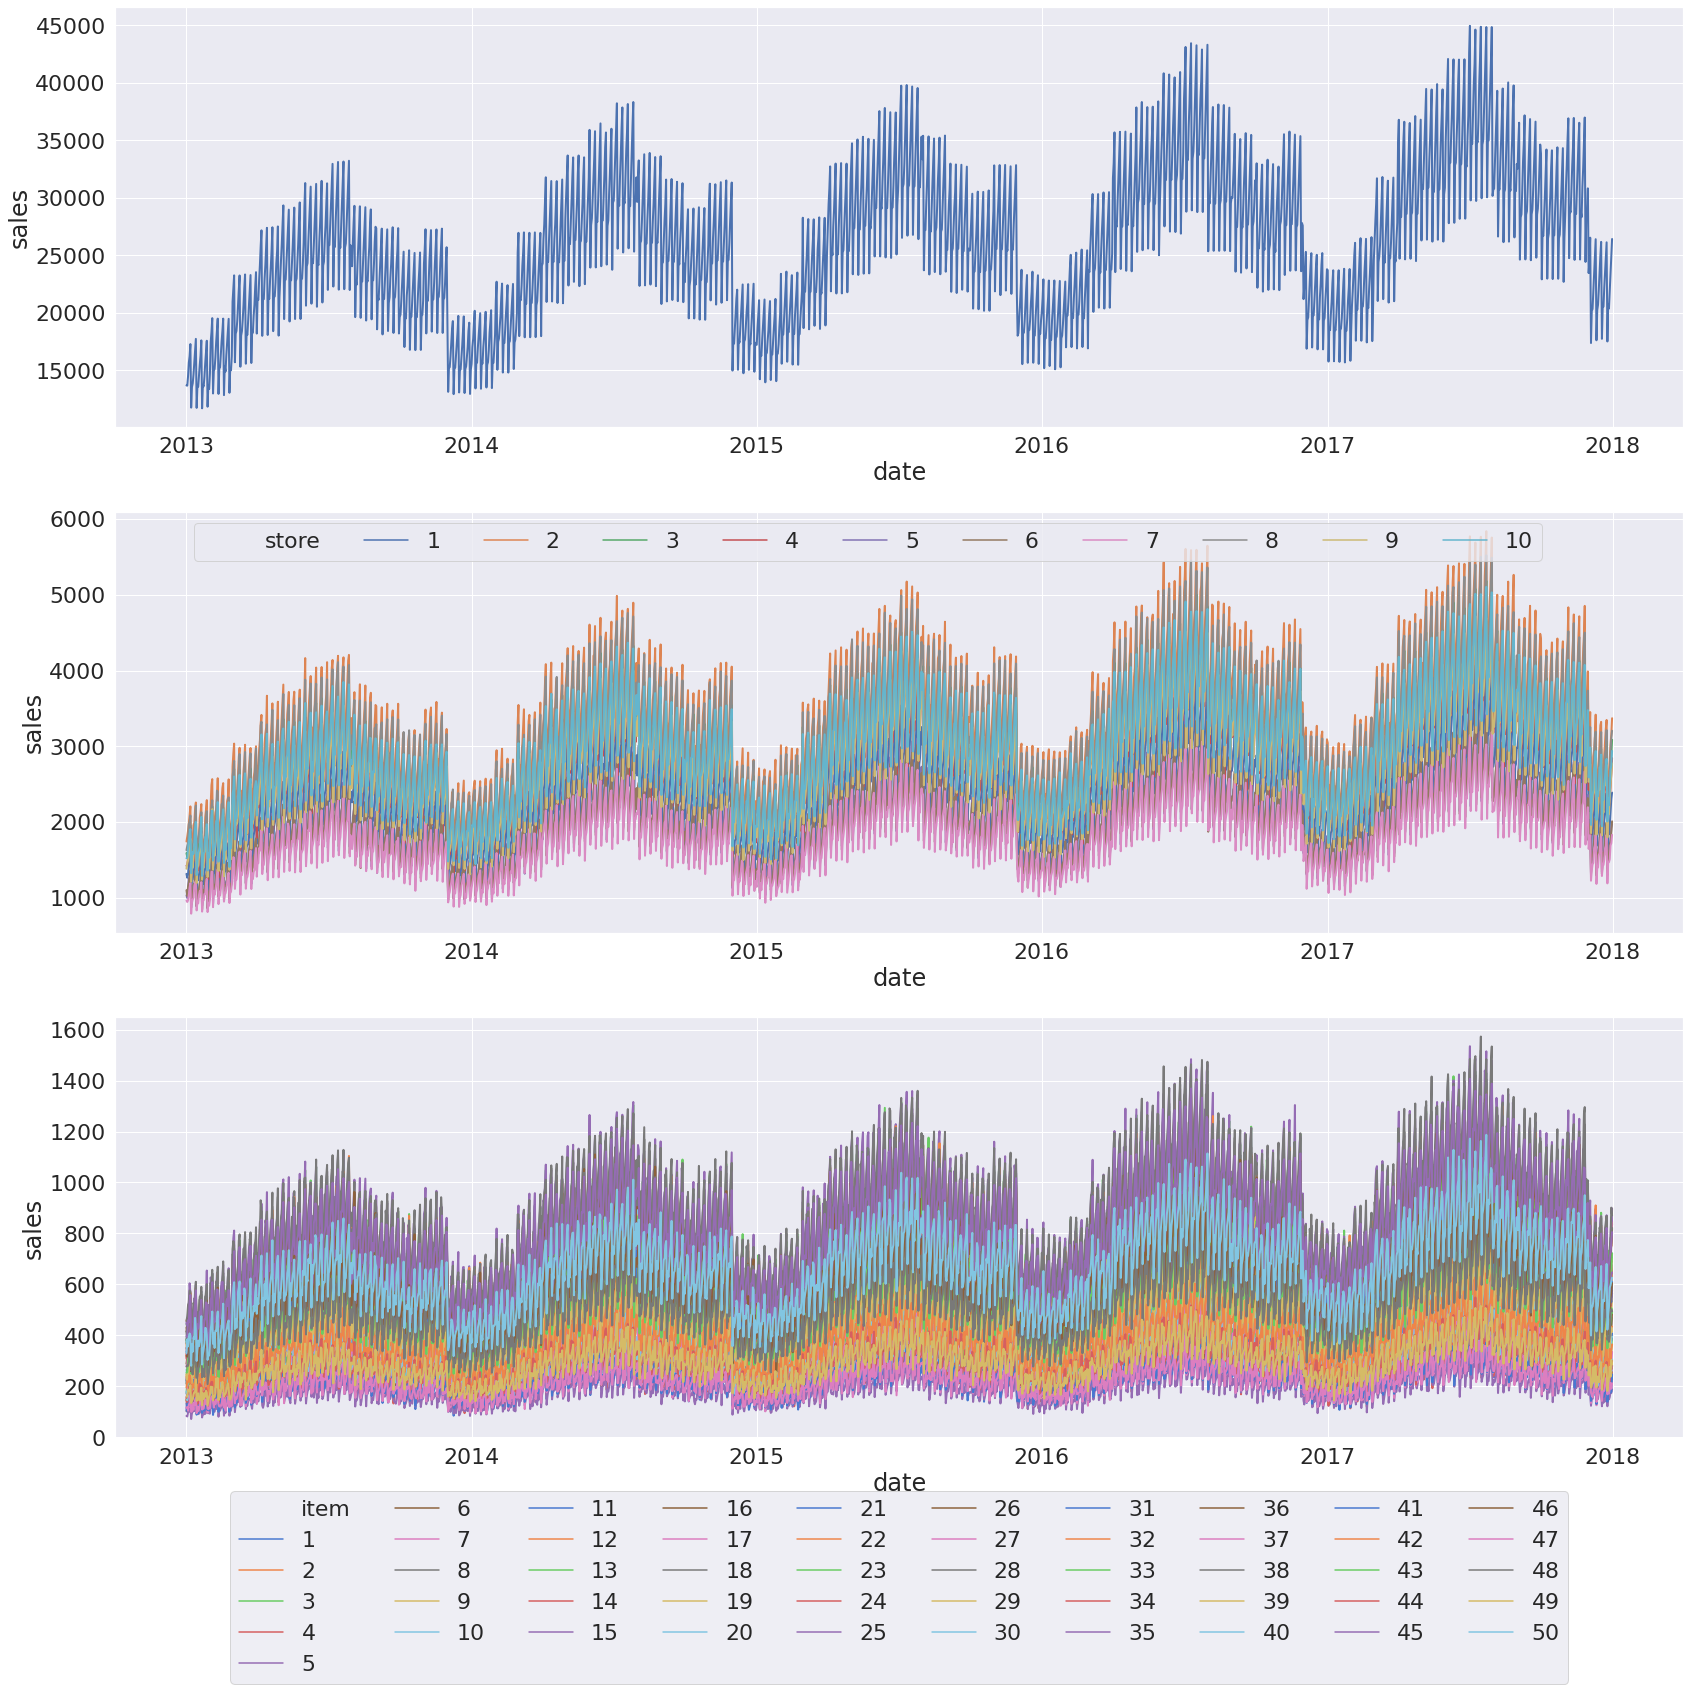

In [ ]:
def sales_timeseries(total, store, item):
  """
  sales_timeseries: Illustrates the time series of total sales, store sales, and item sales
  total: total sales dataframe
  store: store sales dataframe
  item: item sales dataframe
  """
  sns.set(font_scale=2)

  ### Total Sales DataFrame
  sales_df = total.copy()

  ### Stores Sales DataFrame
  sales_stores_df = store.copy()
  # Need to set store numbers to objects that cannot be interpretted as continuous 
  sales_stores_df['store'] = ["$%s$" %x for x in sales_stores_df['store']] 

  ### Items Sales DataFrame
  sales_items_df = item.copy()
  sales_items_df['item'] = ["$%s$" %x for x in sales_items_df['item']]
  
  fig, ax = plt.subplots(3,1,figsize=(24, 24))

  ### Total Sales
  sns.lineplot(x = "date", y="sales", data=sales_df, color = 'b', lw = 2, ax = ax[0])

  ### Store Sales
  sns.lineplot(x = "date", y="sales", data=sales_stores_df, lw = 2, hue = "store",
               hue_order = sales_stores_df['store'].unique(), ax = ax[1])
  ax[1].legend(loc='upper center', bbox_to_anchor=(0.48, 1.0),
          ncol=11, fancybox=True)  
  ### Item Sales
  sns.lineplot(x = "date", y="sales", data=sales_items_df, lw = 2, hue = "item",
               palette = sns.color_palette("muted", 50), hue_order = sales_items_df['item'].unique(), ax = ax[2])
  ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=10, fancybox=True)  
  plt.tight_layout()


sales_timeseries(daily_sales, daily_store_sales, daily_item_sales)

## Sales Histogram

It's also worthwhile to take a look at the distribution of daily sales across all stores and items.

In [ ]:
print('Max daily sale:', train['sales'].max())
print('Min daily sale:', train['sales'].min())
print('Average sale:', train['sales'].mean())

Max daily sale: 231
Min daily sale: 0
Average sale: 52.250286966046005


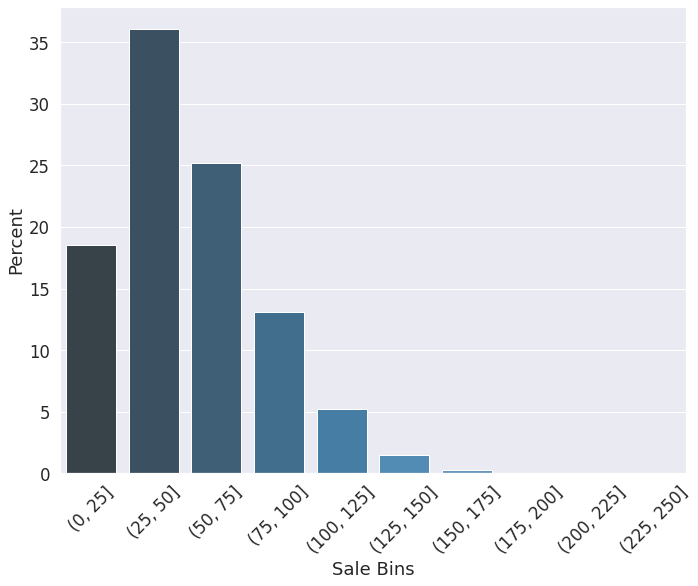

In [ ]:
def sales_hist(data):
    """
        sales_hist: Shows the distribution of daily sales across all stores and items
        data : DataFrame with sales data
    """
    sns.set(font_scale=1.5)
    sales_df = data.copy()
    sales_df['sales_bins'] = pd.cut(sales_df['sales'], 
                                    np.arange(0, 251, 25))
    total_sales = pd.value_counts(sales_df['sales_bins']).sum()
    sales_dist = pd.value_counts(sales_df['sales_bins']).apply(lambda x: x/total_sales*100)
    sales_dist = pd.DataFrame(sales_dist.sort_values(ascending=False)).reset_index()
    sales_dist.columns = ['Sale Bins','Percent']

    ax = plt.figure(figsize=(10,8))
    ax = sns.barplot("Sale Bins", y="Percent", data=sales_dist,
               palette="Blues_d")
    loc, labels = plt.xticks()
    ax.set_xticklabels(labels, rotation=45)

    return sales_dist

sales_df = sales_hist(train)

## Stores and Items Sales Distribution

Now, let's look at how each store and item is doing in terms of sales distribution and average sales.

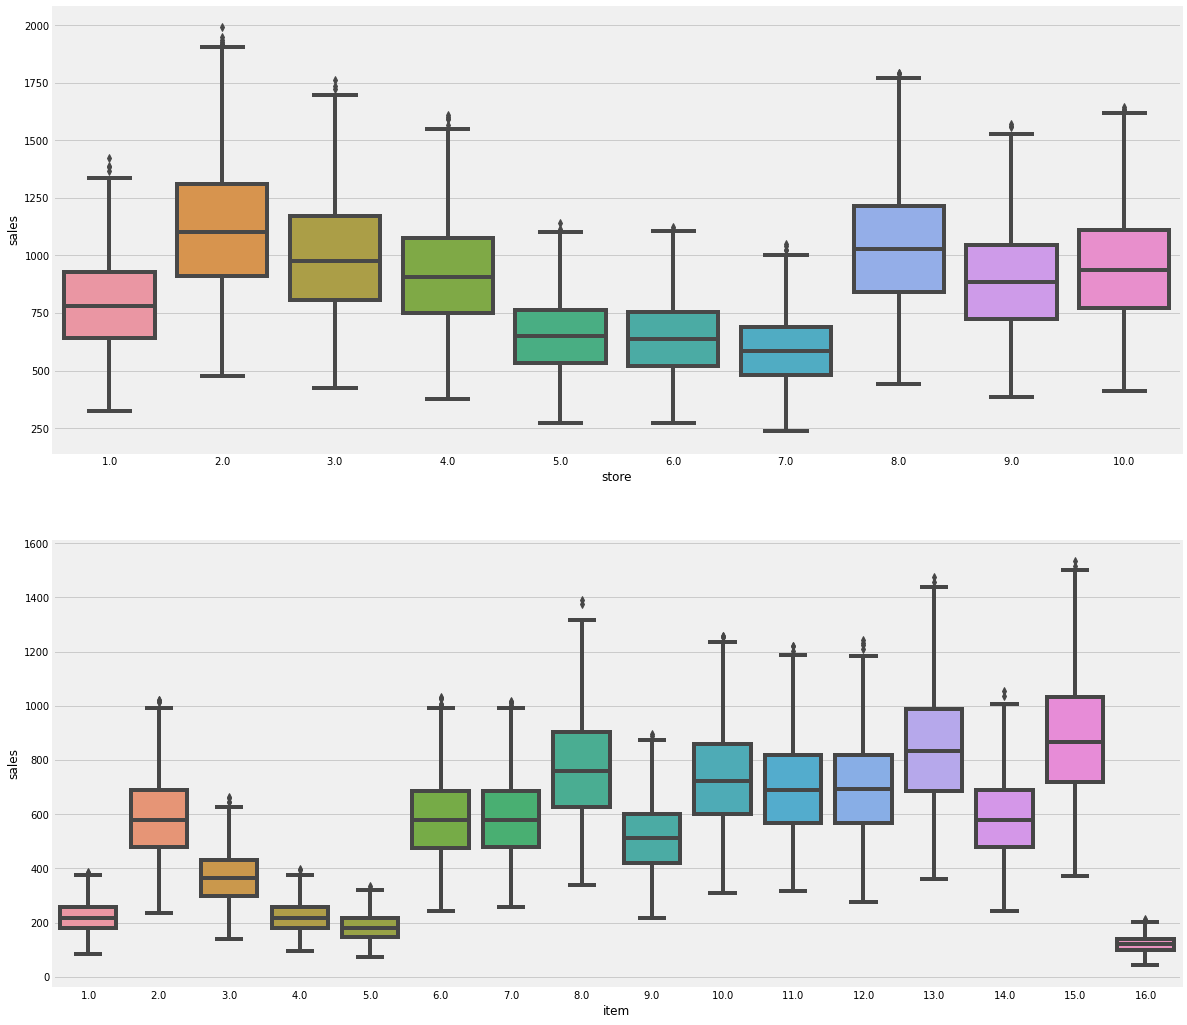

In [6]:
def boxplots(store, item):
  """
    boxplots: Renders boxplots of sales for each store and item.
    store: Dataset containing daily sales information for each store
    item: Dataset containing daily sales information for each item
  """

  ### Stores Sales DataFrame
  sales_stores_df = store.copy()
  # Need to set store numbers to objects that cannot be interpretted as continuous 
  sales_stores_df['store'] = ["$%s$" %x for x in sales_stores_df['store']] 

  ### Items Sales DataFrame
  sales_items_df = item.copy()
  sales_items_df['item'] = ["$%s$" %x for x in sales_items_df['item']]

  fig, ax = plt.subplots(2,1, figsize=(18, 18))

  sns.boxplot(x="store", y="sales", data=sales_stores_df, ax=ax[0])
  sns.boxplot(x="item", y="sales", data=sales_items_df, ax=ax[1])

boxplots(daily_store_sales, daily_item_sales) 

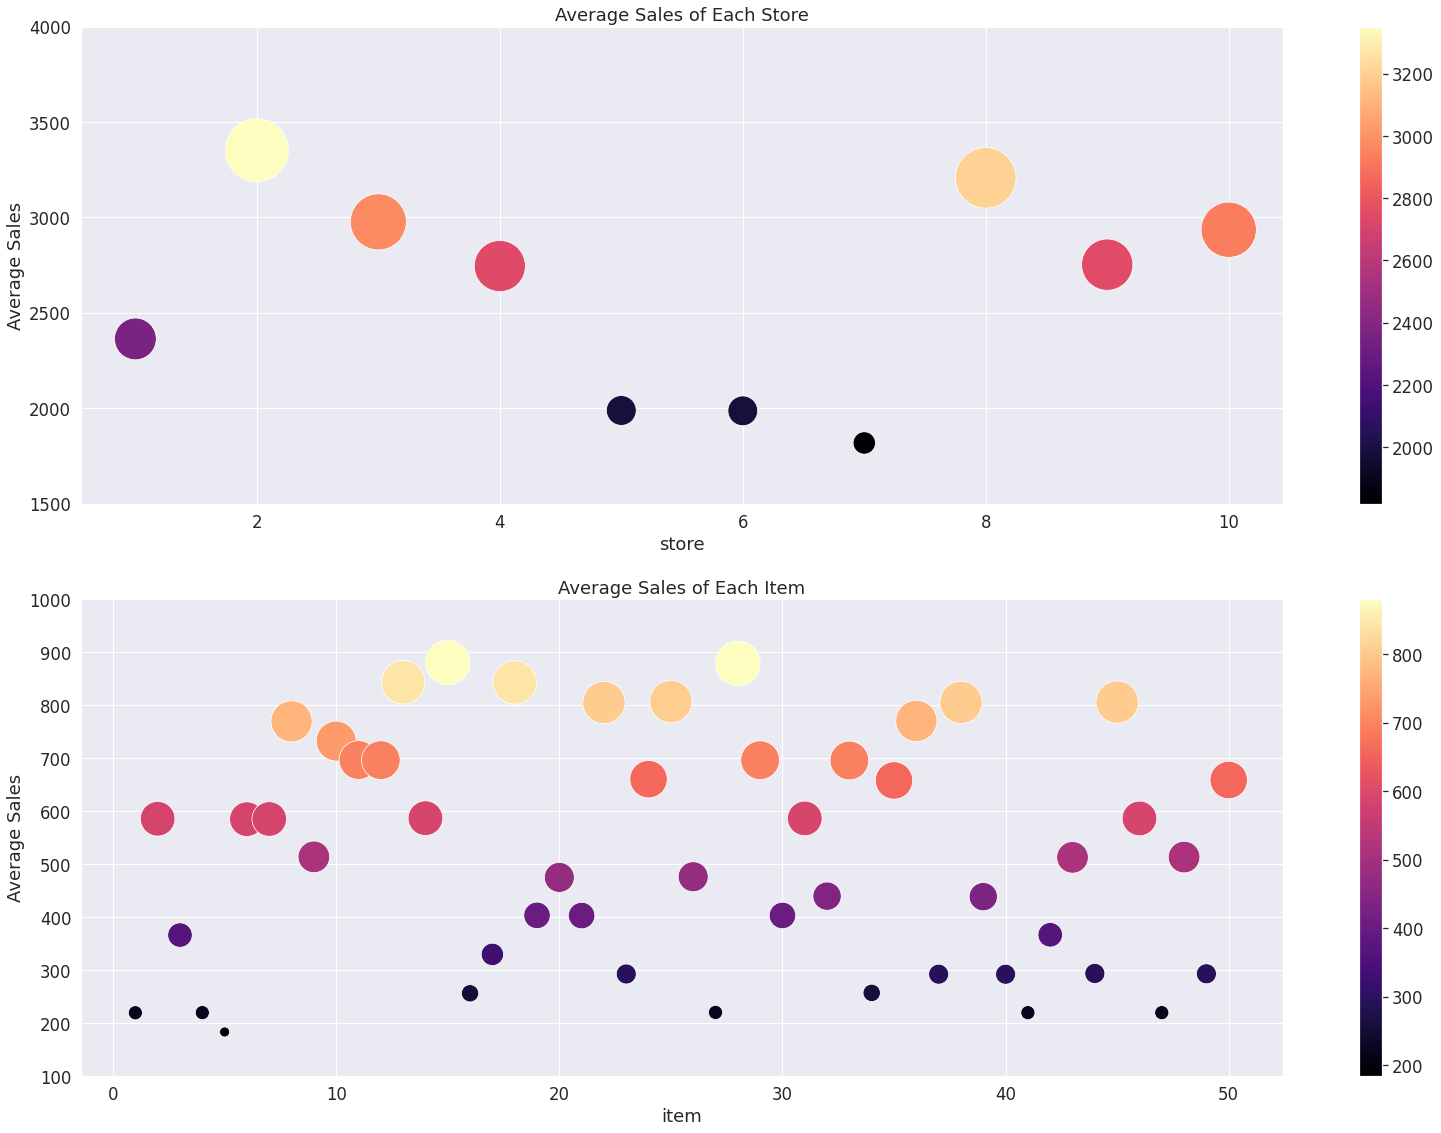

In [ ]:
def average_sales(store, item):    
    """
      average_sales: Plots average sales for each store and item.
      store: Dataset containing daily sales information for each store
      item: Dataset containing daily sales information for each item
    """

    ### Stores Sales 
    sales_stores_df = store.copy()
    stores_avg= pd.DataFrame(sales_stores_df.groupby(['store'])['sales'].mean()).reset_index().sort_values(['store'])

    fig, ax = plt.subplots(2,1, figsize=(24, 18))

    sns.scatterplot(x="store", y="sales", hue = "sales", size="sales",
                    sizes=(500, 4000),data=stores_avg, ax=ax[0], palette='magma')
    ax[0].set_title('Average Sales of Each Store')
    ax[0].set_ylabel('Average Sales')
    ax[0].set_ylim(1500, 4000)

    norm_store = plt.Normalize(stores_avg['sales'].min(), stores_avg['sales'].max())
    sm_store = plt.cm.ScalarMappable(cmap='magma', norm=norm_store)
    sm_store.set_array([])
    ax[0].get_legend().remove()
    plt.colorbar(sm_store, ax=ax[0])

    ### Items Sales 
    sales_items_df = item.copy()
    items_avg= pd.DataFrame(sales_items_df.groupby(['item'])['sales'].mean()).reset_index().sort_values(['item'])
    sns.scatterplot(x="item", y="sales", hue = "sales", size="sales",
                    sizes=(100, 2000),data=items_avg, ax=ax[1], palette='magma')
    ax[1].set_title('Average Sales of Each Item')
    ax[1].set_ylabel('Average Sales')
    ax[1].set_ylim(100, 1000)

    norm_item = plt.Normalize(items_avg['sales'].min(), items_avg['sales'].max())
    sm_item = plt.cm.ScalarMappable(cmap='magma', norm=norm_item)
    sm_item.set_array([])
    ax[1].get_legend().remove()
    plt.colorbar(sm_item, ax=ax[1])

average_sales(daily_store_sales, daily_item_sales)

# Modeling

## Data Preparation

In order to prepare the dataset to be used for time series forecasting, we need to transform the data suitable for a supervised learning task, where the sales of stores or items are predcited using their respective sales at earlier time steps.

In [3]:
def transform_series(data, lag, out, dropnan=True):
    """
      transform_series: Converts series to data used for time series supervised learning
      lag: Times steps used to predict valus
      out: Time step of interest
    """
    cols, names = list(), list()
   
	  # input sequence (t-n, ... t-1)
    for i in range(lag, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in data.columns]
        else:
            names += [('%s(t+%d)' % (col, i)) for col in data.columns]

    # Mergeall together
    new_df = pd.concat(cols, axis=1)
    new_df.columns = names

    # Drop rows with NaN values
    if dropnan:
        new_df.dropna(inplace=True)
    return new_df

In [4]:
def prepare_data(data, lag_size, out_size, downsample_time=None, store=None, item = None):
    """
      prepare_data: Prepares the dataset to be used in the forecasting model
      data: Data containing sales information on stores and items
      lag_size:  Times steps used to predict valus
      out_size: Time steps of interest to the predicted
      downsample_time: The time from which to use data in the model
      store: Specific store to forecast sales
      item: Specific item to forecast sales
    """
    data_mod = data.copy()

    ### Downsample the data to include certain dates
    print('Downsampling the data from {}'.format(downsample_time))

    if downsample_time != None:
        data_mod = data_mod[(data_mod['date']>=downsample_time)]

    ### Prepare dataset, so that each row represents one item in a store
    print('Preparing dataset...')
    data_mod = data_mod.sort_values('date').groupby(['item', 'store', 'date'], 
                                              as_index=False)
    data_mod = data_mod.agg({'sales':['mean']})
    data_mod.columns = ['item', 'store', 'date', 'sales']

    ### Produce the time-series data
    print('Producing time-series data...')
    time_series_data = transform_series(data_mod.drop('date', axis=1), lag=lag_size, out=out_size)

    ### Make each row consistent in terms of the store or item it is representing
    first_item = 'item(t-%d)' % lag_size
    first_store = 'store(t-%d)' % lag_size
    time_series_data = time_series_data[(time_series_data['store(t)'] == time_series_data[first_store])]
    time_series_data = time_series_data[(time_series_data['item(t)'] == time_series_data[first_item])]
    print('Time Series Shape: {}'.format(time_series_data.shape))

    ### Choose a specific store or item to forecast sales for
    if store != None:
        time_series_data = time_series_data[(time_series_data['store(t-{})'.format(lag_size)]==store)]
    if item != None:
        time_series_data = time_series_data[(time_series_data['item(t-{})'.format(lag_size)]==item)]

    ### Remove store and item columns 
    print('Removing store and item columns...')
    drop_cols = list()
    for i in range(lag_size, 0, -1):
        drop_cols += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
    for j in range(1,out_size):
        drop_cols += [('%s(t+%d)' % (col, j)) for col in ['item', 'store']]
    drop_cols += [('%s(t)' % col) for col in ['item', 'store']]

    time_series_data.drop(drop_cols, axis=1, inplace=True)
    print('Time Series Data Shape:{}'.format(time_series_data.shape))
    display(time_series_data.head())
    return time_series_data

In [ ]:
time_series_data = prepare_data(train, lag_size=180, out_size=10, 
                                store=2)

Downsampling the data from None
Preparing dataset...
Producing time-series data...


In [224]:
def create_train_eval(data, lag_size, out_size, test_size, random_state):
    """
      create_train_eval: Creates Train and Eval Datasets
      train_data: The processed time series training data
      lag_size: Times steps used to predict valus
      out_size: Time steps of interest to the predicted
      test_size: The ratio of eval to train dataset used in "train_test_split" function
      random_state: Random state used in "train_test_split" function
    """
    train_data = data.copy()
    ### Separate Label columns from the dataset
    print('Separating labels columns from the dataset ')
    label_cols = ['sales(t)' if out_time==0 else 'sales(t+%d)' % out_time for out_time in range(0, out_size)]
    X = train_data.drop(label_cols, axis=1)

    Y = pd.DataFrame()
    for step_ahead in range(0, out_size):
        Y = pd.concat([Y, train_data.loc[:, train_data.columns.isin(train_data.columns[step_ahead:step_ahead+ lag_size])]],
                      axis=1)

    ### Splitting train and eval datasets
    print('Splitting train and eval dataset...')
    X_train, X_eval, Y_train, Y_eval = train_test_split(X, Y, 
                                                        test_size=0.3, random_state=42)
    
    print('Before Reshaping:')
    print('X_Train:', X_train.shape)
    print('X_eval:', X_eval.shape)
    print('Y_Train:', Y_train.shape)
    print('Y_eval:', Y_eval.shape)

    
    ### Reshape Train and Eval datasets so that it becomes [batch_size, time_steps, features]

    X_train_re = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_eval_re = X_eval.values.reshape((X_eval.shape[0], X_eval.shape[1], 1))
    Y_train_re = Y_train.values.reshape((Y_train.shape[0], X_train.shape[1], out_size))
    Y_eval_re = Y_eval.values.reshape((Y_eval.shape[0], X_eval.shape[1], out_size))

    print('After Reshaping:')
    print('X_Train_re:', X_train_re.shape)
    print('X_eval_re:', X_eval_re.shape)
    print('Y_Train_re:', Y_train_re.shape)
    print('Y_eval_re:', Y_eval_re.shape)
    
    return X_train_re, X_eval_re, Y_train_re, Y_eval_re

In [265]:
X_train, X_eval, Y_train, Y_eval = create_train_eval(time_series_data, lag_size=30, 
                                                     out_size=5, test_size=0.3, random_state=42)

Separating labels columns from the dataset 
Splitting train and eval dataset...
Before Reshaping:
X_Train: (1257, 30)
X_eval: (539, 30)
Y_Train: (1257, 150)
Y_eval: (539, 150)
After Reshaping:
X_Train_re: (1257, 30, 1)
X_eval_re: (539, 30, 1)
Y_Train_re: (1257, 30, 5)
Y_eval_re: (539, 30, 5)


## Forecasting with LSTM Model

In [269]:
"""
  LSTM Model
"""
lstm_model = Sequential([
    LSTM(200, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    Dropout(rate=0.2),
    LSTM(200, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(100, return_sequences=True),
    Dropout(rate=0.1),
    TimeDistributed(Dense(5))
])

lstm_model.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.MeanSquaredError()])
checkpoint_cb = ModelCheckpoint("LSTM_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=1,restore_best_weights=True)

In [270]:
num_epochs = 25
history = lstm_model.fit(X_train, 
                         Y_train, 
                         epochs=num_epochs,
                         validation_data=(X_eval, Y_eval))

Train on 1257 samples, validate on 539 samples
Epoch 1/25
1257/1257 [==============================] - 11s 9ms/step - loss: 274.9499 - mean_squared_error: 335.9014 - val_loss: 186.8088 - val_mean_squared_error: 259.3874
Epoch 2/25
1257/1257 [==============================] - 10s 8ms/step - loss: 145.1429 - mean_squared_error: 226.1031 - val_loss: 110.4988 - val_mean_squared_error: 197.9462
Epoch 3/25
1257/1257 [==============================] - 10s 8ms/step - loss: 89.6264 - mean_squared_error: 177.4435 - val_loss: 71.7836 - val_mean_squared_error: 160.0432
Epoch 4/25
1257/1257 [==============================] - 10s 8ms/step - loss: 63.1092 - mean_squared_error: 146.3494 - val_loss: 54.8499 - val_mean_squared_error: 134.8785
Epoch 5/25
1257/1257 [==============================] - 10s 8ms/step - loss: 52.1255 - mean_squared_error: 125.5966 - val_loss: 48.0379 - val_mean_squared_error: 117.7827
Epoch 6/25
1257/1257 [==============================] - 10s 8ms/step - loss: 48.3025 - mean_sq

In [271]:
"""
  Evaluating Performace of the model on train and eval datasets
"""
train_pred = lstm_model.predict(X_train)
eval_pred = lstm_model.predict(X_eval)

train_pred_re = train_pred.reshape((train_pred.shape[0], train_pred.shape[1]*train_pred.shape[2]))
eval_pred_re = eval_pred.reshape((eval_pred.shape[0], eval_pred.shape[1]*eval_pred.shape[2]))
Y_train_re = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]*Y_train.shape[2]))
Y_eval_re = Y_eval.reshape((Y_eval.shape[0], Y_eval.shape[1]*Y_eval.shape[2]))

print('Train rmse:', np.sqrt(mean_squared_error(Y_train_re, train_pred_re)))
print('Eval rmse:', np.sqrt(mean_squared_error(Y_eval_re, eval_pred_re)))

Train rmse: 6.795253919306193
Eval rmse: 6.699070858790753


In [273]:
pd.DataFrame(train_pred_re).to_csv("/train_pred_csv.csv")

In [274]:
pd.DataFrame(eval_pred_re).to_csv("/eval_pred_csv.csv")

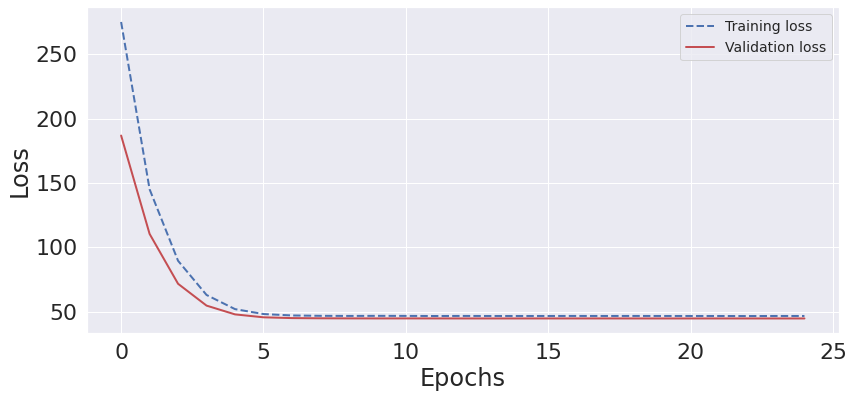

In [275]:
def plot_loss(loss, val_loss):
    """
      plot_loss: Visualizes Train and Eval loss progress over training epochs
      loss: Train loss obtained from the model
      val_loss: Eval loss obtained from the model
    """
    plt.figure(figsize=(12,6))
    ax = sns.lineplot(np.arange(len(loss)), loss, color="b", 
                      label="Training loss", lw=2)
    ax = sns.lineplot(np.arange(len(val_loss)), val_loss, color="r", label="Validation loss", lw=2)
    ax.lines[0].set_linestyle("--")

    ax.legend(fontsize=14)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")


plot_loss(history.history["loss"], history.history["val_loss"])


In [215]:
def pred_plot(X, Y_data, Y_pred, train_data, lag_size, out_size):
    """
      pred_plot: Illustrates time series of actual and forecast data
      X: Dataset containing data prior to forecast period 
      Y_data: Dataset containing actual values for the forecast period
      pred_data: Dataset containing forecast values
      train_data: Original training dataset containing dates and sales information for all stores and items
      lag_size: Times steps used to predict valus
      out_size: Time steps of interest to the predicted
    """
    sns.set(font_scale=2)

    ### X Dataset 
    X = X.copy()
    X = pd.concat([X, train_data['date'].reset_index(drop=True)], axis=1)
    X.columns = ['sales','date']
    X.loc[:out_size,'sales']=np.nan

    ### Actual Dataset for the Forecast period 
    Y = Y_data.copy()
    Y = pd.concat([Y, train_data['date'].reset_index(drop=True)], axis=1)
    Y.columns = ['sales','date']
    Y.loc[:lag_size-out_size,'sales']=np.nan

    ### Forecast Dataset  
    Y_pred = Y_pred.copy()
    Y_pred = pd.concat([Y_pred, train_data['date'].reset_index(drop=True)], axis=1)
    Y_pred.columns = ['sales','date']
    Y_pred.loc[:lag_size-out_size,'sales']=np.nan

    plt.figure(figsize=(18, 6))
    ax = sns.lineplot(x = "date", y="sales", data=X, color = 'b', lw = 2)
    ax = sns.lineplot(x = "date", y="sales", data=Y, color = 'purple', lw = 2, label="Actual")
    ax = sns.lineplot(x = "date", y="sales", data=Y_pred, color = 'r', lw = 2, label="Forecast")
    plt.tight_layout()
  

In [277]:
eval_pred = lstm_model.predict(X_eval[-1,:,:][np.newaxis,...])[0,:,-1]

In [ ]:
"""
  Visualize the forecast results compared to the true values
"""
train_mod = train[((train['store']==1) & (train['item']==1) & (train['date'] >= '2017-12-01'))]
X = X_eval[-1,:,0]
X = pd.DataFrame(X)
Y = Y_eval[-1,:,-1]
Y = pd.DataFrame(Y)
Y_pred = pd.DataFrame(eval_pred)
pred_timeseries(X, Y, Y_pred,train_mod, 30, 5)